In [3]:
import numpy as np
import deeptrack as dt
import deeplay as dl
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


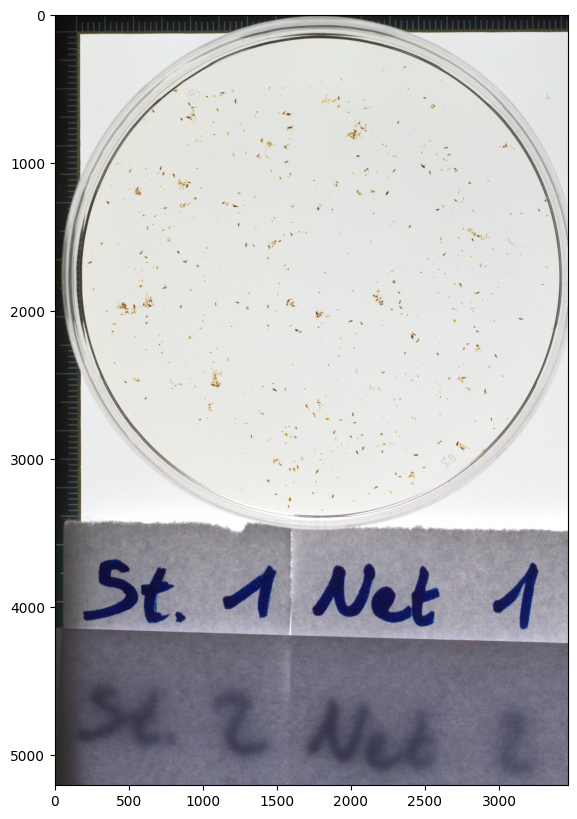

In [4]:
image = dt.LoadImage("cope_1.png")

plt.figure(figsize=(15, 10))
image = np.array(image.resolve()) #Note to self, resolve makes it into a list
plt.imshow(image)

# Prepare cropped sample

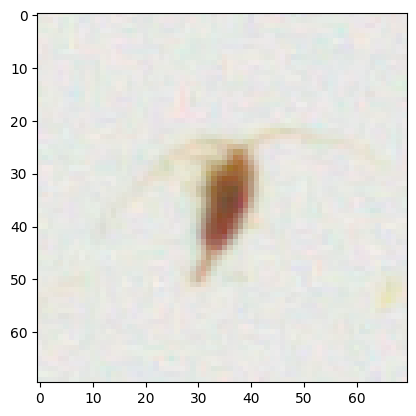

In [5]:
crop_size = 70
y_index = 1970
x_index = 850


'''
Example crop for cope_1.png:

crop_size = 70
y_index = 1970
x_index = 850

'''


x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
crop = np.array(image[x0:x0+crop_size, y0: y0 + crop_size])
plt.imshow(crop)

In [6]:
training_pipeline = (
    dt.Value(crop)
    >> dt.Multiply(lambda: np.random.uniform(0.9, 1.1))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)
training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, replace=False)

In [7]:
dataloader = dl.DataLoader(training_dataset,batch_size=8,shuffle=True,num_workers=5)

# Train LodeSTAR

In [8]:
epochs = 7
lodestar = dl.LodeSTAR(n_transforms=4,optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=epochs)
trainer.fit(lodestar,dataloader)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/alex/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-03-28 19:29:10.304356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 19:29:10.415242: W tensorflow/stream_executor/platform/default/dso_loader.cc:64]

Epoch 6: 100%|██████████| 50/50 [00:23<00:00,  2.15it/s, v_num=11, train_between_image_disagreement_step=0.0405, train_within_image_disagreement_step=0.0139, train_between_image_disagreement_epoch=0.0347, train_within_image_disagreement_epoch=0.0172]


# Evaluate Performance

Text(0.5, 1.0, 'Input overlay with bitmask')

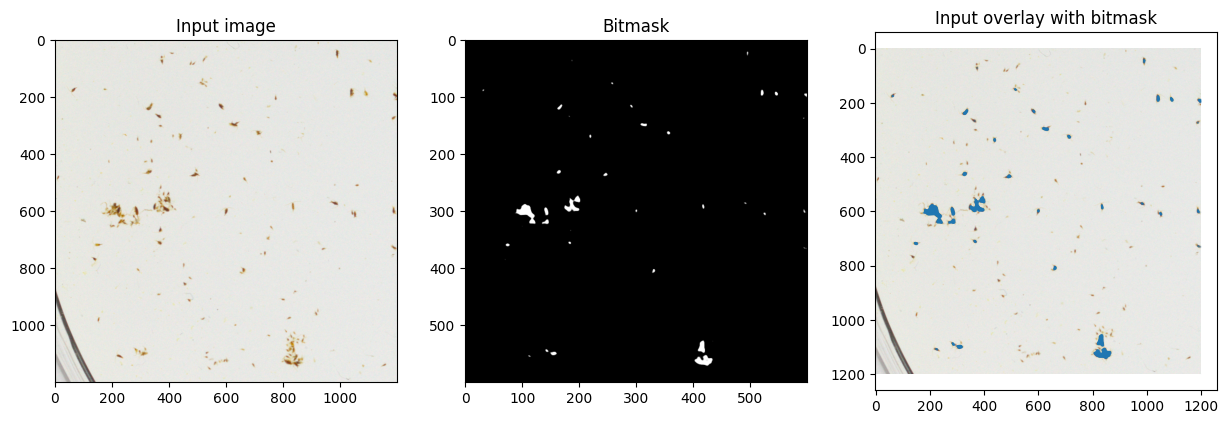

In [15]:
crop_size= 1200
y_index = 1970
x_index = 850

x0,y0 = y_index-crop_size // 2, x_index - crop_size//2
crop = image[x0:x0+crop_size, y0: y0 + crop_size]



torch_image = torch.from_numpy(crop).permute(2,0,1).unsqueeze(0).float()
prediction = lodestar(torch_image)[0].detach().numpy()
x, y, rho = prediction[0], prediction[1], prediction[-1]

plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(crop)
plt.title("Input image")

plt.subplot(1,3,2)
plt.imshow(rho,cmap="grey")
plt.title("Predicted image")

plt.subplot(1,3,3)
plt.imshow(crop)
plt.scatter(y.flatten(),x.flatten(),alpha=rho.flatten()/rho.max(),s=0.05)
plt.title("Input overlay with bitmask")
